In [ ]:
from google.colab import files
uploaded = files.upload()


Saving archive (8).zip to archive (8).zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("archive (8).zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")  # This will create a folder named 'dataset'


In [ ]:
import os
import shutil
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
dataset_path = "/content/dataset/dataset_blood_group"

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Step 1: Load dataset
dataset = image_dataset_from_directory(
  dataset_path,
  labels="inferred",
  label_mode="int",
  image_size=(64, 64), # Resize images to standard size
  batch_size=BATCH_SIZE,
  shuffle=True
)

Found 6000 files belonging to 8 classes.


In [ ]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
  class_counts[int(labels.numpy())] += 1

print("Class Distribution")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution
B+: 652
AB+: 708
B-: 741
A-: 1009
O+: 852
A+: 565
AB-: 761
O-: 712


In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    - class_names (list): List of class names.
    - class_counts (dict): Dictionary with class indices as keys and counts as values.

    Returns:
    - None
    """
    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


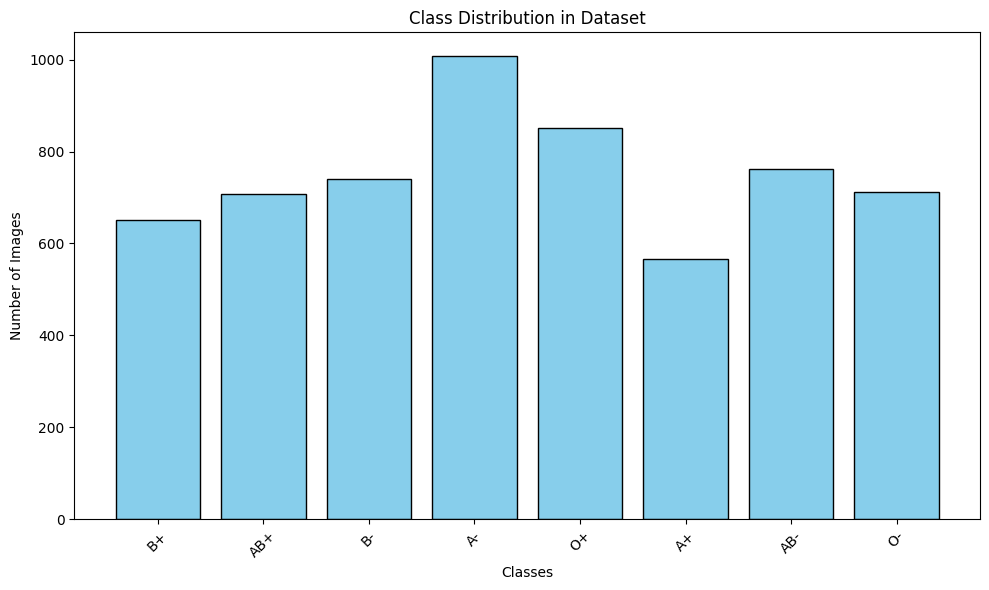

In [ ]:
# Assuming class_names and class_counts are already calculated
plot_class_distribution(class_names, class_counts)

In [ ]:
max_count = max(class_counts.values())

In [ ]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
  # Ensure the dataset is unbatched for filtering
  unbatched_dataset = dataset.unbatch()

  # Filter the dataset for the specific class
  class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

  # Calculated the number of reptitions needed
  repeat_factor = max_count // count + (max_count % count > 0)

  # Repeat the dataset to match the desired count
  return class_dataset.repeat(repeat_factor).take(max_count)

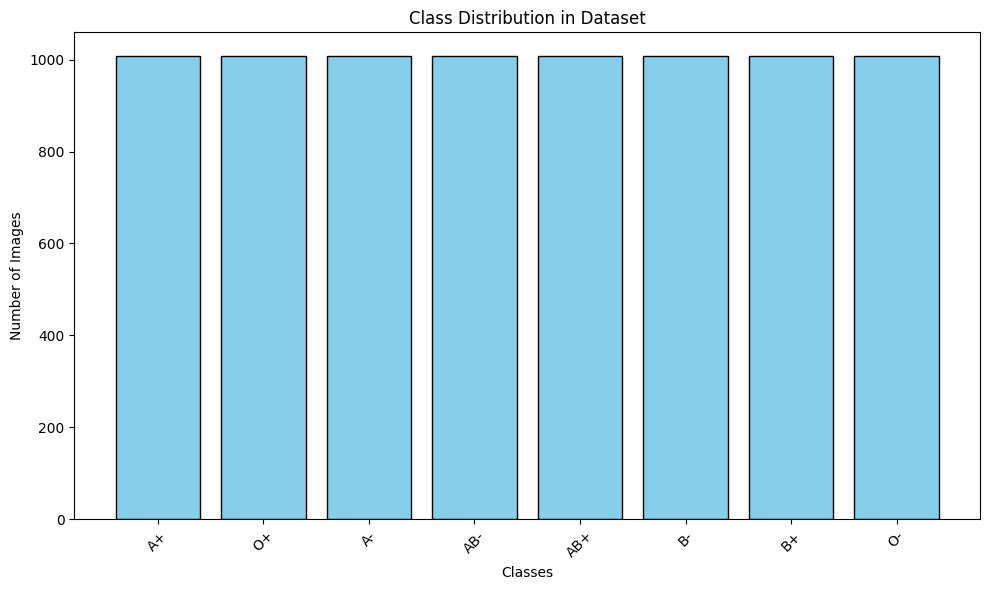

In [ ]:
# Step 1: Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Step 2: Combine balanced datasets (still unbatched)
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# ✅ Step 3: Count class distribution (before batching)
balanced_labels = [int(lbl.numpy()) for _, lbl in balanced_dataset.take(10000)]  # sample 10k items or use .unbatch()
balanced_class_counts = Counter(balanced_labels)
plot_class_distribution(class_names, balanced_class_counts)

# Step 4: Batch the dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
for sample in balanced_dataset.take(10):
  print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [ ]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [ ]:
# Unbatch to operate on individual samples
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Count total number of samples
dataset_size = sum(1 for _ in balanced_dataset_unbatched)

# Re-create unbatched dataset (since iterators are exhausted after sum)
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1  # remaining

# Compute sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)

val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Count batches
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")


Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [ ]:
# Define the model creation function
def create_high_accuracy_model(num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model with correct class count
num_classes = 8
high_acc_model = create_high_accuracy_model(num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Watch validation loss
    factor=0.5,                # Reduce learning rate by half
    patience=3,                # Wait 3 epochs before reducing
    verbose=1,                 # Print update messages
    min_lr=1e-6                # Avoid reducing too much
)

# Callback to stop early if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',            # Watch validation loss
    patience=5,                    # Wait 5 epochs before stopping
    verbose=1,                     # Print message when stopping
    restore_best_weights=True      # Keep best model
)


In [ ]:
# ✅ Train the model safely
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop],
    verbose=1  # Optional: shows progress
)


Epoch 1/50
    176/Unknown 16s 32ms/step - accuracy: 0.1196 - loss: 41.2825

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.1197 - loss: 41.1099 - val_accuracy: 0.1125 - val_loss: 2.0792 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.1787 - loss: 2.0424 - val_accuracy: 0.3975 - val_loss: 1.8790 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4364 - loss: 1.5277 - val_accuracy: 0.3756 - val_loss: 1.6591 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.5519 - loss: 1.1787 - val_accuracy: 0.4194 - val_loss: 1.5467 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6185 - loss: 1.0242 - val_accuracy: 0.6400 - val_loss: 1.3362 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.6742 - loss: 0.8809 - val_accuracy: 0.7375 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.6968 - loss: 0.82

In [ ]:
# Evaluate the model on validation data
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9411 - loss: 0.2856
High Accuracy Model - Loss: 0.2908799648284912, Accuracy: 0.9356250166893005


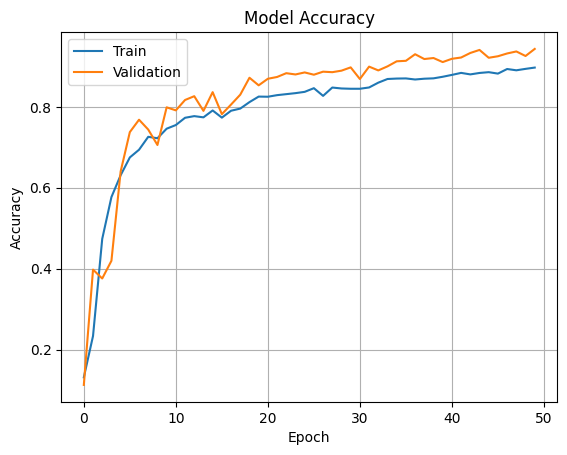

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Call the function to display the accuracy graph
plot_accuracy(history_high_acc)


# Explanation
# ---------------------------------

# epoch increasing , and accuracy also increasing

# vaidation accuracy good which the 95 and training nearby 85

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Classification Report:
              precision   

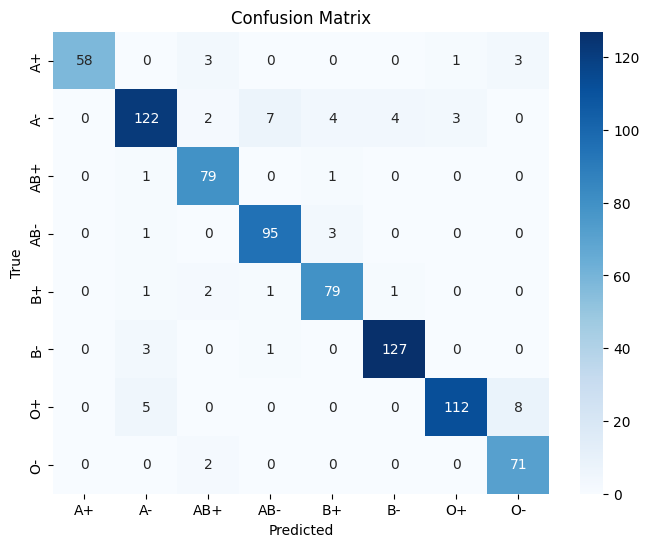

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels
    y_true.extend(labels.numpy())                      # Convert to numpy array and append
    y_pred.extend(predicted_labels)                    # Append predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
high_acc_model.save('model.h5')
print("Model saved in HDF5 format.")

Model saved in HDF5 format.
